In [130]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

df_all = pd.read_csv("C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\UntrackedCode\\TestData\\AllFts.csv")
df_all = df_all.drop(['Unnamed: 0'], axis=1)
df_all = df_all[~df_all['Feature'].isin(['firstorder_Minimum', 'firstorder_Maximum'])]
df_all = df_all[df_all['ContourType'] == 'Manual']

In [131]:
fts = df_all.Feature.unique()
patIDs = df_all.PatID.unique()

In [140]:
df_res = pd.DataFrame(columns=['PatID','Feature', 'Frac1', 'PeakFrac', 'PeakTrt','LongPeakVal', 'LongPeakPc', 'DeltaPeakVal', 'DeltaPeakPc'])

for ft in fts:
    df_ft = df_all[df_all.Feature == ft]

    for pat in patIDs:
        df_pat = df_ft[df_ft.PatID == pat]

        val_frac1 = df_pat.FeatureValue.values[0]
        vals_trt = np.abs(df_pat.FeatureValue.values[1:])
        idx_max = np.argmax(df_pat.FeatureValue.values) + 1
        idx_peak = np.argmax(vals_trt)
        val_peak = vals_trt[idx_peak]
        val_long_pc = (abs((val_peak - val_frac1)) / val_frac1) * 100
        val_del = vals_trt[-1]
        val_del_pc = ((val_peak - val_del) / val_peak) * 100

        idx_peak = idx_peak + 2
        # add to df_res
        df_res = df_res.append({'PatID': pat, 'Feature': ft, 'Frac1': val_frac1, 'PeakFrac': idx_max, 'PeakTrt': idx_peak,'LongPeakVal':val_peak, 'LongPeakPc':val_long_pc, 'DeltaPeakVal':val_del, 'DeltaPeakPc':val_del_pc}, ignore_index=True)



In [141]:
df_res

,PatID,Feature,Frac1,PeakFrac,PeakTrt,LongPeakVal,LongPeakPc,DeltaPeakVal,DeltaPeakPc
0,1642,shape_Elongation,0.839757,4,4,0.972982,15.864631,0.966507,0.665497
1,713,shape_Elongation,0.777558,3,3,0.891851,14.698889,0.801409,10.140932
2,1483,shape_Elongation,0.915607,3,3,0.958514,4.686169,0.853234,10.983623
3,1089,shape_Elongation,0.721896,4,4,0.833181,15.415624,0.821395,1.414510
4,829,shape_Elongation,0.796941,5,5,0.851933,6.900421,0.851933,0.000000
...,...,...,...,...,...,...,...,...,...
2095,826,ngtdm_Strength,0.036732,3,3,0.079329,115.966263,0.027694,65.089236
2096,1601,ngtdm_Strength,0.092189,2,2,0.168397,82.665644,0.011227,93.333016
2097,1481,ngtdm_Strength,0.365749,2,2,0.412746,12.849644,0.410458,0.554454
2098,1431,ngtdm_Strength,0.189220,5,5,0.344240,81.926214,0.344240,0.000000


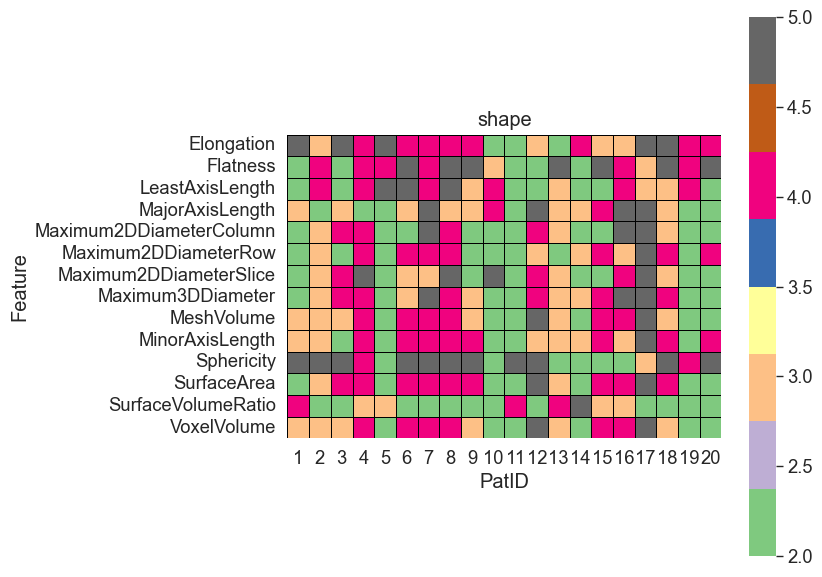

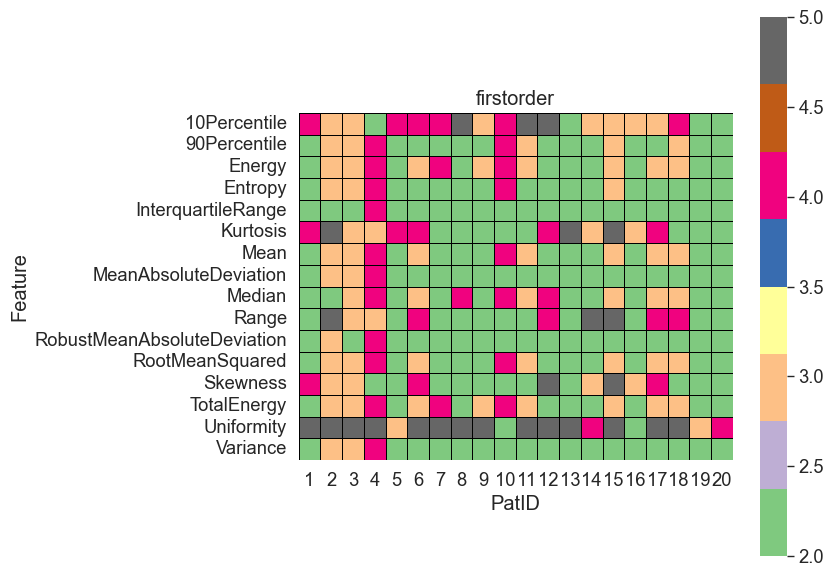

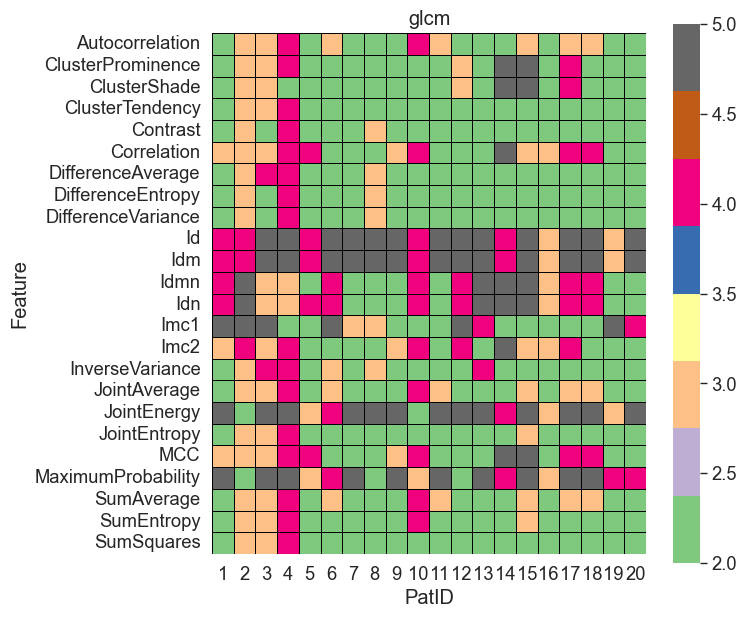

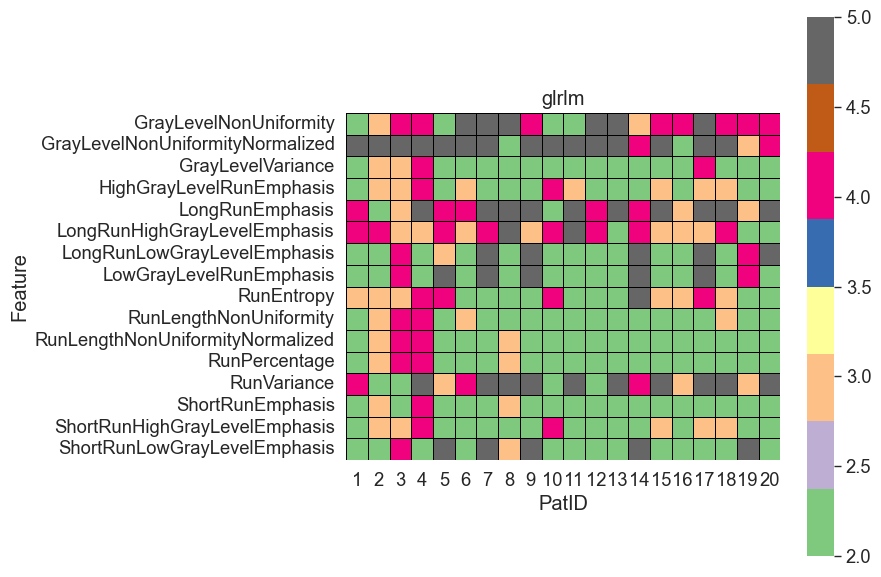

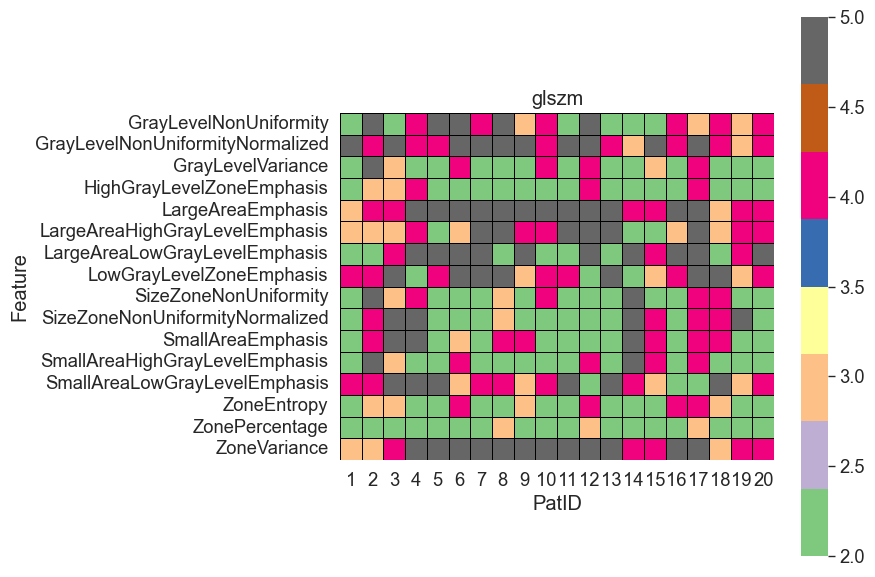

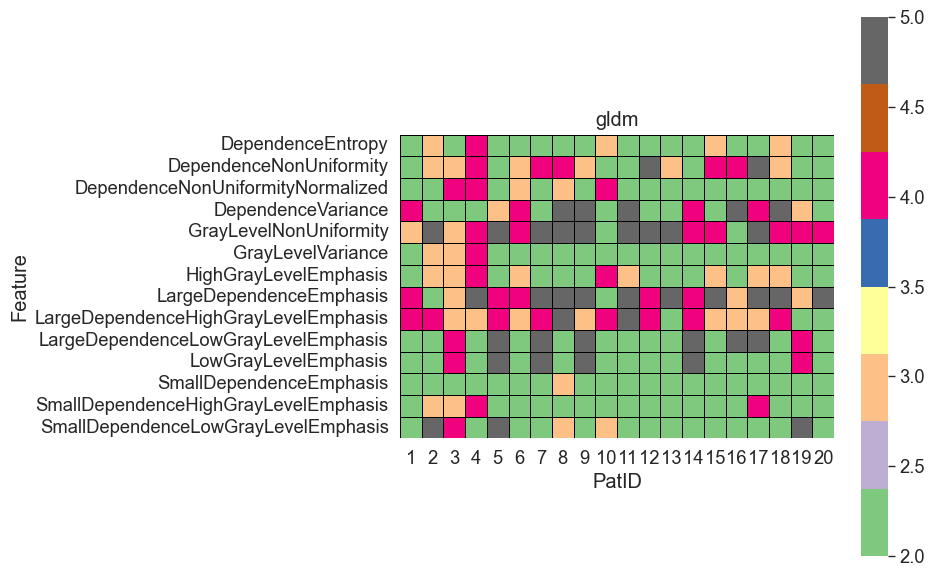

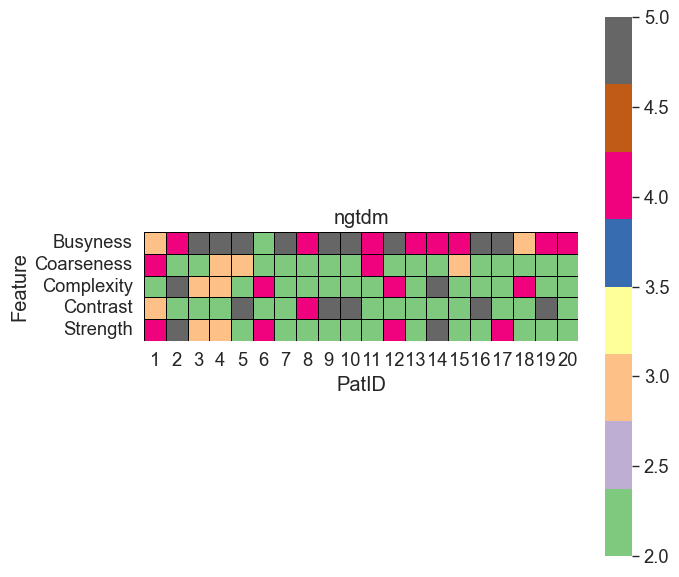

In [142]:
df_res['Group'] = df_res['Feature'].str.split('_').str[0]
grps = df_res['Group'].unique()
for g in grps:
    df_hm = df_res[df_res['Group'] == g]
    df_hm = df_hm.pivot(index='PatID', columns='Feature', values='PeakFrac')
    df_hm = df_hm.T

    df_hm = df_hm.fillna(0)
    df_hm = df_hm.astype(int)


    plt.figure(figsize=(7,7))
    sns.set_theme(style="darkgrid")
    sns.set_context("paper", font_scale=1.5)

    # set only 4 potential colors
    cmap = sns.color_palette("muted", as_cmap=True,)
    ax = sns.heatmap(df_hm, annot=False, linewidths=0.5, linecolor='black', cbar=True, square=True, cmap='Accent', vmin=2, vmax=5)
    
    ax.set_xticklabels(np.arange(1, 21, 1), rotation=0)
    ylabs = ax.get_yticklabels()
    # remove g from y labels
    ylabs = [x.get_text().split('_')[1] for x in ylabs]
    ax.set_yticklabels(ylabs, rotation=0)

    # # set colour bar to discrete
    # ax.collections[0].colorbar.set_ticks([2, 3, 4, 5])
    # ax.collections[0].colorbar.set_ticklabels(['2', '3', '4', '5'])
    # ax.collections[0].colorbar.set_label('Peak Fraction')
    # ax.collections[0].colorbar.set_label('Peak Fraction', rotation=270, labelpad=20)
     
    # make colour bar discrete
    
    plt.title(g)

    # change colour bar to discrete

    


    plt.show()

In [143]:
# get most common peak fraction for each feature
df_res['PeakFrac'] = df_res['PeakFrac'].astype(int)

df_out = pd.DataFrame(columns=['Feature', 'PeakFrac', 'Count'])

for ft in fts:
    df_ft = df_res[df_res.Feature == ft]
    df_ft = df_ft['PeakTrt'].value_counts().reset_index(name='Count')

    # get most common peak fraction
    peak_frac = df_ft['index'].values[0]
    count = df_ft['Count'].values[0]

    df_out = df_out.append({'Feature': ft, 'PeakFrac': peak_frac, 'Count': count}, ignore_index=True)

df_out.to_csv("C:\\Users\\b01297ar\\Documents\\ProstateMRL-local\\ProstateMRL-Radiomics\\UntrackedCode\\TestData\\df_peakfrac.csv", index=False)

# find how many rows peaked at 5
df_out['PeakFrac'].value_counts()

2    54
5    27
4    18
3     6
Name: PeakFrac, dtype: int64